<a href="https://colab.research.google.com/github/ScienceMoo/DNA_structure_ML/blob/main/Binary_WithShapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline

import math
import seaborn; seaborn.set() # Plot styling
from seaborn import heatmap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
# actual PWM
actualPWM = np.array([[0.0540, 0.3180, 0.5660, 0.0620],
    [0.0240, 0.6460, 0.0240, 0.3060],
    [0.0680, 0.0420, 0.7920, 0.0980],
    [0.0420, 0.7900, 0.0620, 0.1060],
    [     0, 0.9940,      0, 0.0060],
    [0.2620, 0.6660, 0.0460, 0.0260],
    [0.0040, 0.6180, 0.0020, 0.3760],
    [     0, 0.9980, 0.0020,      0],
    [0.0320, 0.0640, 0.0080, 0.8960],
    [0.2660, 0.0900, 0.5640, 0.0800],
    [0.0200, 0.3440, 0.6200, 0.0160],
    [0.0800, 0.1940, 0.0440, 0.6820],
    [0.0100, 0.0020, 0.9760, 0.0120],
    [0.0260, 0.0660, 0.8400, 0.0680],
    [0.1260, 0.5940, 0.0740, 0.2060]])

# Read data

In [109]:
### Load positive binding sequences
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_sequences.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

sequences = mat['sequences']
sequences = [word[2:33] for word_array in sequences for word in word_array[0]]
sequences = np.array(sequences)
num_sample, seq_length = sequences.shape[0], sequences.shape[1]
print("sequences.shape =", sequences.shape)
print("num_sample =", num_sample)
print("seq_length =", seq_length)
# print("sequences =", sequences[:5])


### Load binding strengths of positive sequences
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_strengths.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

strengths = mat['TF_scores']
strengths = [thing[0] for thing in strengths]
y = np.array(strengths)
print("\ny.shape =", y.shape)


### Load shapes of positive sequences
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_shapes.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

positive_shapes = mat['shapes']

positive_shapes = np.array(positive_shapes)
print("")
print("positive_shapes.shape =", positive_shapes.shape)
# print("positive_shapes =", positive_shapes[0])


### Load false binding sequences
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "false_sequences.mat"
file_path = file_folder + "/" + file_name
mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)
false_sequences = mat['false_sequences']

false_sequences = [word[2:33] for word_array in false_sequences for word in word_array[0]]
false_sequences = np.array(false_sequences)

num_false_seq = false_sequences.shape[0]
print("\nfalse_sequences.shape =", false_sequences.shape)
print("num_false_seq =", num_false_seq)
print("seq_length =", seq_length)
# print("false_sequences =", false_sequences[:5])


### Load shapes of false sequences
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_false_shapes.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

false_shapes = mat['shapes']

false_shapes = np.array(false_shapes)
print("")
print("false_shapes.shape =", false_shapes.shape)
# print("false_shapes =", false_shapes[0])

sequences.shape = (158004, 31)
num_sample = 158004
seq_length = 31

y.shape = (158004,)

positive_shapes.shape = (158004, 31, 4)

false_sequences.shape = (160135, 31)
num_false_seq = 160135
seq_length = 31

false_shapes.shape = (160135, 31, 4)


In [110]:
# Clean the data
inds = []
for idx, sequence in enumerate(sequences):
  if 'N' in sequence:
    inds.append(idx)

sequences = np.delete(sequences, inds, axis=0)
positive_shapes = np.delete(positive_shapes, inds, axis=0)

num_sample, seq_length = sequences.shape[0], sequences.shape[1]

print("num_sample =", num_sample)
print("seq_length =", seq_length)

print("sequences.shape =", sequences.shape)

print("positive_shapes.shape =", positive_shapes.shape)

inds = []
for idx, sequence in enumerate(false_sequences):
  if 'N' in sequence:
    inds.append(idx)

false_sequences = np.delete(false_sequences, inds, axis=0)
false_shapes = np.delete(false_shapes, inds, axis=0)

false_sequences = false_sequences[0:num_sample]
false_shapes = false_shapes[0:num_sample]

num_false_seq = false_sequences.shape[0]
print("num_false_seq =", num_false_seq)
print("false_shapes.shape =", false_shapes.shape)

num_sample = 158004
seq_length = 31
sequences.shape = (158004, 31)
positive_shapes.shape = (158004, 31, 4)
num_false_seq = 158004
false_shapes.shape = (158004, 31, 4)


# Prepare data

In [111]:
# one-hot encoding
X = np.zeros(list(sequences.shape) + [8])
false_X = np.zeros(list(false_sequences.shape) + [8])

# X = np.zeros(list(sequences.shape) + [4])
# false_X = np.zeros(list(false_sequences.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

for row in range(num_sample):
    for col in range(seq_length):
        X[row,col,base_dict[sequences[row,col]]] = 1
        X[row,col,4:] = positive_shapes[row, col, :]
        # X[row,col,:] = positive_shapes[row, col, :]

for row in range(num_false_seq):
    for col in range(seq_length):
        false_X[row,col,base_dict[false_sequences[row,col]]] = 1
        false_X[row,col,4:] = false_shapes[row, col, :]
        # false_X[row,col,:] = false_shapes[row, col, :]

X_data = np.around(np.vstack((X, false_X)), 3)
y = np.vstack((np.transpose(np.repeat([[0], [1]], num_sample, axis=1)), np.transpose(np.repeat([[1], [0]], num_false_seq, axis=1))))

print('Training set shape: {}'.format(X_data.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nInput data looks like:\n {}'.format(X_data[0,0,:]))

print('\nTarget looks like:\n {}'.format(y[0]))

Training set shape: (316008, 31, 8)
Training set label shape: (316008, 2)

Input data looks like:
 [0.    0.    0.    1.    0.799 0.664 0.553 0.446]

Target looks like:
 [0 1]


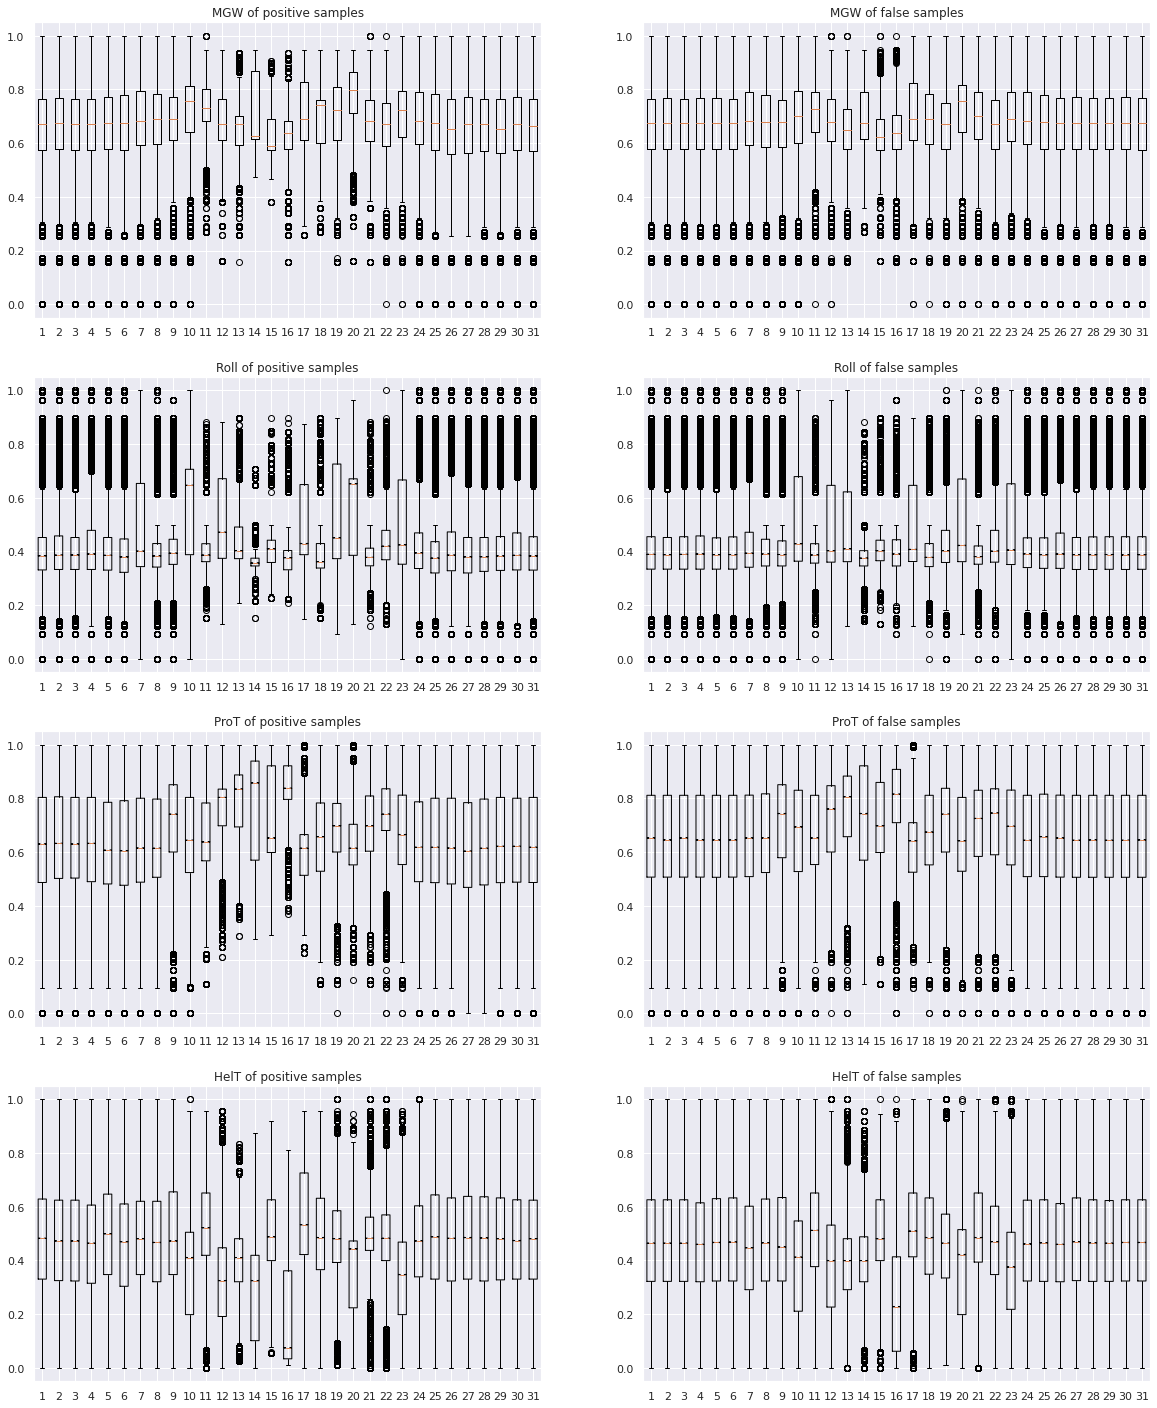

In [118]:
fig=plt.figure(figsize=(20, 25))
plt.subplot(4, 2, 1)
plt.boxplot(X[:, :, 4])
plt.title("MGW of positive samples")

plt.subplot(4, 2, 2)
plt.boxplot(false_X[:, :, 4])
plt.title("MGW of false samples")

plt.subplot(4, 2, 3)
plt.boxplot(X[:, :, 5], 10)
plt.title("Roll of positive samples")

plt.subplot(4, 2, 4)
plt.boxplot(false_X[:, :, 5], 10)
plt.title("Roll of false samples")

plt.subplot(4, 2, 5)
plt.boxplot(X[:, :, 6], 10)
plt.title("ProT of positive samples")

plt.subplot(4, 2, 6)
plt.boxplot(false_X[:, :, 6], 10)
plt.title("ProT of false samples")

plt.subplot(4, 2, 7)
plt.boxplot(X[:, :, 7], 10)
plt.title("HelT of positive samples")

plt.subplot(4, 2, 8)
plt.boxplot(false_X[:, :, 7], 10)
plt.title("HelT of false samples")
plt.show()

In [119]:
X, X_test, y, y_test = train_test_split(X_data, y, test_size=0.05)

# Deep Learning

In [152]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD
import keras

# define the model
model = Sequential()
model.add(Conv1D(128, 25, padding='same', activation='relu', input_shape=(seq_length, 8)))

#sanity check for dimensions
print('Shape of the output of first layer: {}'.format(model.predict_on_batch(X[0:32,:,:]).shape))
# model.add(MaxPooling1D(4))

# model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.0003, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=100)  # starts training
model.evaluate(X_test, y_test)

model.summary()

Shape of the output of first layer: (32, 31, 128)
Epoch 1/50
2402/2402 [==============================] - 34s 14ms/step - loss: 0.5218 - accuracy: 0.7798 - val_loss: 0.3998 - val_accuracy: 0.8569
Epoch 2/50
2402/2402 [==============================] - 33s 14ms/step - loss: 0.3311 - accuracy: 0.8913 - val_loss: 0.2756 - val_accuracy: 0.9141
Epoch 3/50
2402/2402 [==============================] - 33s 14ms/step - loss: 0.2438 - accuracy: 0.9292 - val_loss: 0.2181 - val_accuracy: 0.9396
Epoch 4/50
2402/2402 [==============================] - 34s 14ms/step - loss: 0.2026 - accuracy: 0.9430 - val_loss: 0.1894 - val_accuracy: 0.9480
Epoch 5/50
2402/2402 [==============================] - 34s 14ms/step - loss: 0.1808 - accuracy: 0.9500 - val_loss: 0.1754 - val_accuracy: 0.9476
Epoch 6/50
2402/2402 [==============================] - 33s 14ms/step - loss: 0.1677 - accuracy: 0.9538 - val_loss: 0.1636 - val_accuracy: 0.9569
Epoch 7/50
2402/2402 [==============================] - 37s 15ms/step - lo

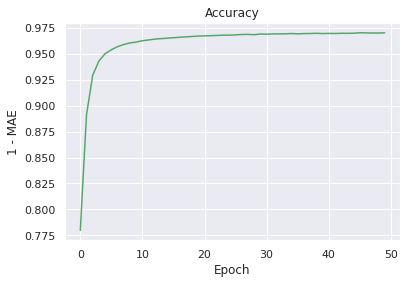

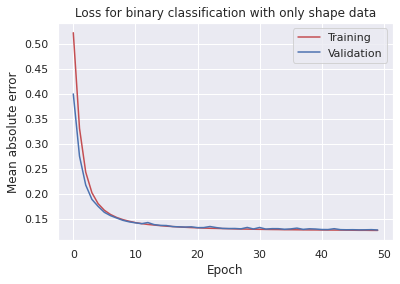

In [153]:
plt.plot(hist.epoch, hist.history['accuracy'], 'g')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("1 - MAE")
plt.show()

acc = hist.history['accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# np.save("hist_shapes_only_999", acc, loss, val_loss)

plt.plot(hist.epoch, hist.history['loss'], 'r', label="Training")
plt.plot(hist.epoch, hist.history['val_loss'], 'b', label="Validation")
plt.title("Loss for binary classification with only shape data")
plt.xlabel("Epoch")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

In [75]:
def my_softmax(row):
  if min(row) != 0:
    row = row - min(row)
  return row / sum(row)

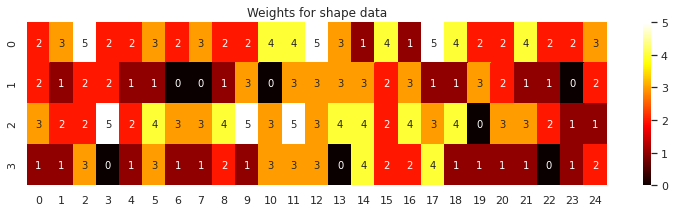

Convolution parameter shape: (4, 25)


In [166]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
weights = np.mean(np.transpose(weights)[:, 4:], 0)
# weights = np.transpose(weights)[1, 4:]
# print(weights)
weights = weights * 500
weights = weights.astype(int)

fig=plt.figure(figsize=(13, 3))
heatmap(weights,  annot=True, fmt="d", cmap="hot")
plt.title("Weights for shape data")
plt.show()
# weights = np.apply_along_axis(my_softmax, 1, weights)
print('Convolution parameter shape: {}'.format(weights.shape))

Convolution parameter shape: (25, 8, 128)


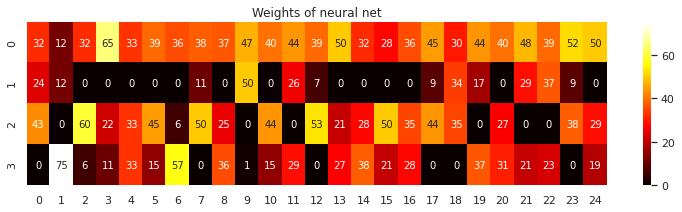

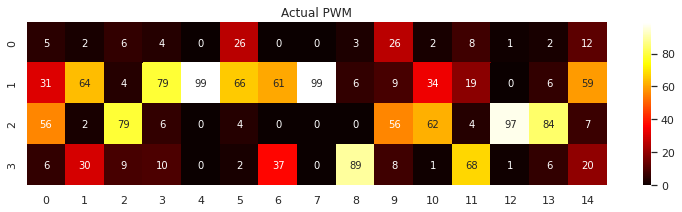

In [167]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))
# weights = np.apply_along_axis(my_softmax, 1, weights)
weights = np.mean(np.transpose(weights)[:, :4], 0)

weights = np.transpose(weights)
weights = np.apply_along_axis(my_softmax, 1, weights)

weights = weights * 100
weights = weights.astype(int)

fig=plt.figure(figsize=(13, 3))
heatmap(np.transpose(weights),  annot=True, fmt="d", cmap="hot")
plt.title("Weights of neural net")
plt.show()


fig=plt.figure(figsize=(13, 3))
heatmap(np.transpose((actualPWM * 100).astype(int)), annot=True, fmt="d", cmap="hot")
plt.title("Actual PWM")
plt.show()

In [136]:
num2seq = ['A','C','G','T']
''.join([num2seq[np.argmax(actualPWM[i,:])] for i in range(actualPWM.shape[0])])  

'GCGCCCCCTGGTGGC'

In [137]:
# predict highest strength sequence
num2seq = ['A','C','G','T']
''.join([num2seq[np.argmax(weights[i,:4])] for i in range(weights.shape[0])])  

'AAAAAAAAAAAAAAAAAAAAAAAAA'

In [138]:
# predict lowest strength sequence
num2seq = ['A','C','G','T']
''.join([num2seq[np.argmin(weights[i,:4])] for i in range(weights.shape[0])])

'CCCGCCCCCCCCCCCCCCCCCCCCC'

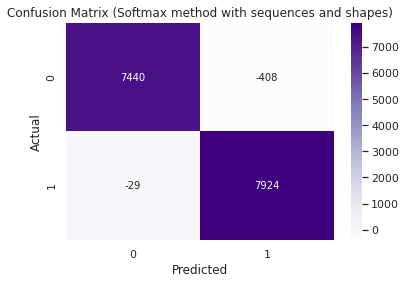

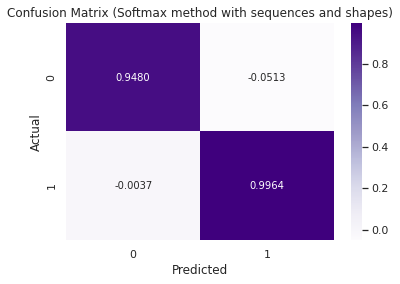

In [175]:
# Test the model
pred = model.predict(X_test)

y_actual = np.array([np.argmax(i) for i in y_test])
y_pred = np.array([np.argmax(i) for i in pred])


true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for i in range(y_actual.shape[0]):
  if y_pred[i] == 1 and y_actual[i] == 1:
    true_positives += 1
  elif y_pred[i] == 0 and y_actual[i] == 1:
    false_negatives += 1
  elif y_pred[i] == 1 and y_actual[i] == 0:
    false_positives += 1
  elif y_pred[i] == 0 and y_actual[i] == 0:
    true_negatives += 1

confusion = [[true_negatives, false_positives], [false_negatives, true_positives]]
confusion = np.array(confusion)
confusion = - confusion
np.fill_diagonal(confusion, - confusion.diagonal())

heatmap(confusion, annot=True, fmt="d", cmap="Purples")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Softmax method with sequences and shapes)')
plt.show()

# np.save("confusion_shapes_only_999", confusion)

total_positive = (true_positives + false_negatives)
total_negative = (true_negatives + false_positives)

true_positives = true_positives / total_positive
false_positives = false_positives / total_positive
true_negatives = true_negatives / total_negative
false_negatives = false_negatives / total_negative

confusion = [[true_negatives, false_positives], [false_negatives, true_positives]]
confusion = np.array(confusion)
confusion = - confusion
np.fill_diagonal(confusion, - confusion.diagonal())

heatmap(confusion, annot=True, fmt=".4f", cmap="Purples")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Softmax method with sequences and shapes)')
plt.show()